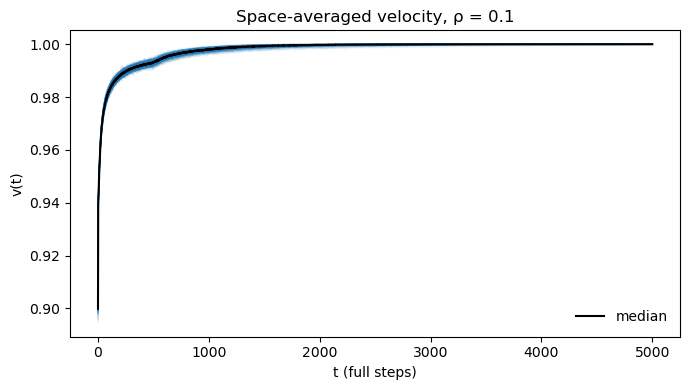

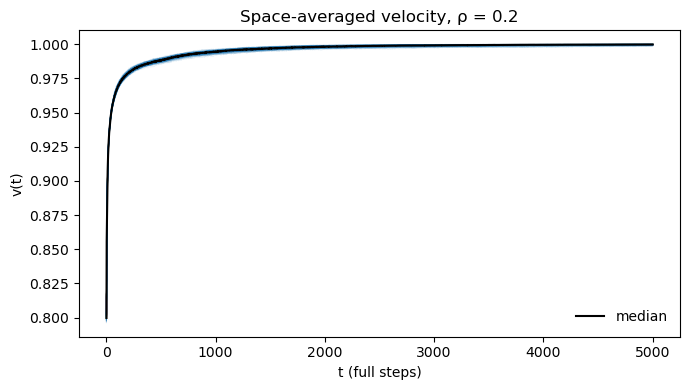

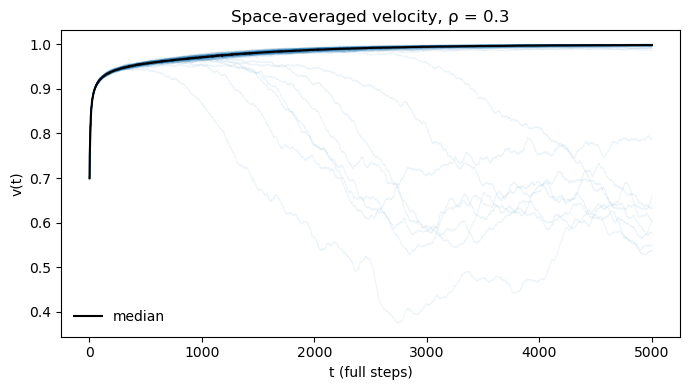

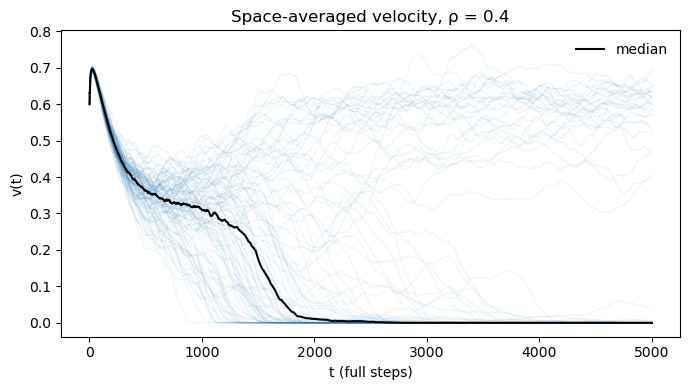

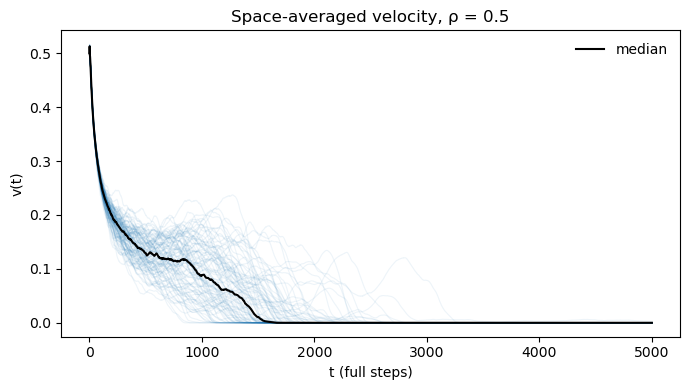

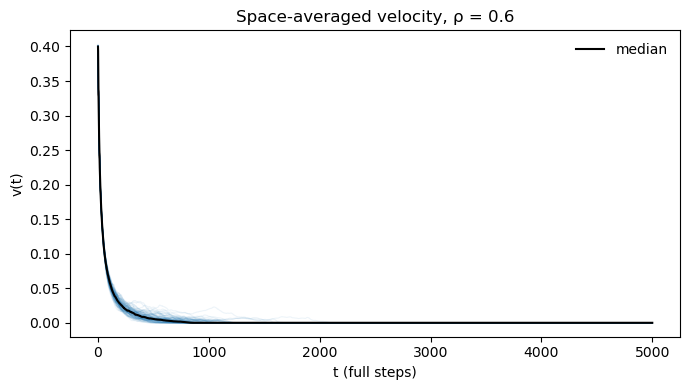

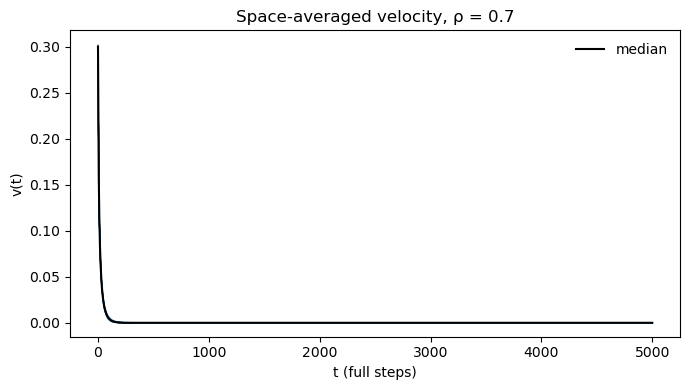

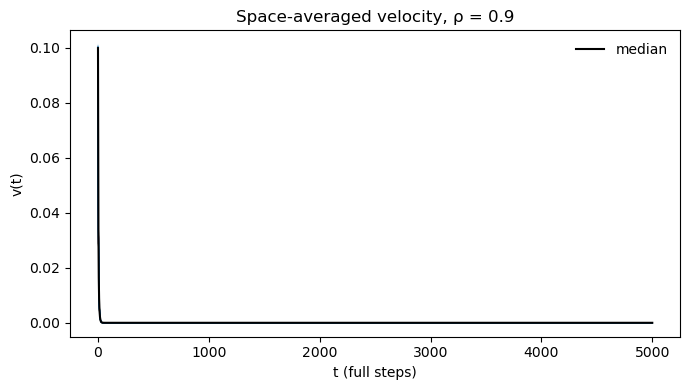

Global T_R_max (0-based index) = 4149
Global T_R_max (full-step count) = 4150

Ensemble results (TR is 0-based index; add +1 for full-step time):
rho=0.1 | <TR>=32.0±0.0 | <D>=2.511e+05±2.171e+04 | <Dn>=2.421e-04±2.093e-05 | censored=0.0%
rho=0.2 | <TR>=34.0±0.0 | <D>=1.108e+06±8.638e+04 | <Dn>=1.068e-03±8.328e-05 | censored=0.0%
rho=0.3 | <TR>=208.2±611.7 | <D>=1.082e+07±1.673e+07 | <Dn>=1.043e-02±1.613e-02 | censored=0.0%
rho=0.4 | <TR>=1768.4±982.1 | <D>=3.201e+08±6.908e+07 | <Dn>=3.087e-01±6.660e-02 | censored=0.0%
rho=0.5 | <TR>=1635.3±439.8 | <D>=4.928e+08±7.146e+06 | <Dn>=4.751e-01±6.890e-03 | censored=0.0%
rho=0.6 | <TR>=607.5±232.4 | <D>=6.187e+08±5.097e+05 | <Dn>=5.965e-01±4.914e-04 | censored=0.0%
rho=0.7 | <TR>=109.7±4.3 | <D>=7.252e+08±2.071e+04 | <Dn>=6.991e-01±1.997e-05 | censored=0.0%
rho=0.9 | <TR>=0.0±0.0 | <D>=9.334e+08±1.140e+03 | <Dn>=8.999e-01±1.099e-06 | censored=0.0%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# PARAMETERS
# ============================================================
L = 500
RHOS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
DATA_DIR = Path("./bml_3D_data_rho_scan")  # folder with vel_rhoXX.bin

# Spaghetti plot styling
ALPHA = 0.08
LW = 0.8
SHOW_MEDIAN = True

# Relaxation-time detection parameters (simple + robust)
SMOOTH_W = 100        # moving-average window (removes small wiggles)
TAIL_W = 750         # tail window to define final plateau value/noise
PERSIST_W = 300      # must stay in final band for this long
K_SIGMA = 3          # band width = max(EPS_MIN, K_SIGMA * sigma_tail)
EPS_MIN = 0.005      # minimum band width (handles super-flat tails)

# ============================================================
# HELPERS: IO + tags
# ============================================================
def rho_tag(rho):
    return f"rho{int(round(rho * 100))}"

def read_vel_bin(path: Path) -> np.ndarray:
    """
    Binary format:
      int32 T
      int32 M
      M*T float64, row-major [m][t]
    Returns: array shape (M, T)
    """
    with open(path, "rb") as f:
        T = np.fromfile(f, dtype=np.int32, count=1)[0]
        M = np.fromfile(f, dtype=np.int32, count=1)[0]
        data = np.fromfile(f, dtype=np.float64, count=M * T)
    return data.reshape(M, T)

# ============================================================
# HELPERS: smoothing + relaxation time detection
# ============================================================
def smooth(v: np.ndarray, W: int = 50) -> np.ndarray:
    """Simple moving average smoothing (same length output)."""
    if W <= 1:
        return v.copy()
    kernel = np.ones(W) / W
    return np.convolve(v, kernel, mode="same")

def relaxation_time(
    v: np.ndarray,
    smooth_window: int = SMOOTH_W,
    tail_window: int = TAIL_W,
    persist_window: int = PERSIST_W,
    k_sigma: float = K_SIGMA,
    eps_min: float = EPS_MIN
) -> int:
    """
    Define relaxation time T_R as the first time the SMOOTHED curve
    enters its final (tail) noise band and stays there for persist_window.

    Returns:
      T_R as an integer (0-based index).
      If no plateau detected, returns T-1 (censored at end).
    """
    T = len(v)
    vs = smooth(v, smooth_window)

    tw = min(tail_window, T)
    tail = vs[-tw:]

    v_inf = np.median(tail)
    sigma = np.std(tail)
    eps = max(eps_min, k_sigma * sigma)

    # search for first sustained entry into final band
    last_start = T - persist_window
    if last_start <= 0:
        return T - 1

    for t in range(last_start):
        window = vs[t:t + persist_window]
        if np.all(np.abs(window - v_inf) <= eps):
            return t

    return T - 1

# ============================================================
# PART A: SPAGHETTI PLOTS (your original visualization)
# ============================================================
def spaghetti_plots():
    for rho in RHOS:
        tag = rho_tag(rho)
        path = DATA_DIR / f"vel_{tag}.bin"

        v_all = read_vel_bin(path)   # shape (M, T)
        M, T = v_all.shape
        t = np.arange(1, T + 1)

        plt.figure(figsize=(7, 4))

        # translucent spaghetti
        for m in range(M):
            plt.plot(t, v_all[m], color="tab:blue", alpha=ALPHA, linewidth=LW)

        # optional median curve
        if SHOW_MEDIAN:
            plt.plot(
                t, np.median(v_all, axis=0),
                color="black", linewidth=1.5, label="median"
            )

        plt.xlabel("t (full steps)")
        plt.ylabel("v(t)")
        plt.title(f"Space-averaged velocity, ρ = {rho}")
        if SHOW_MEDIAN:
            plt.legend(frameon=False)
        plt.tight_layout()
        plt.show()

# ============================================================
# PART B: COMPUTE RELAXATION TIMES, GLOBAL T_R_max, DELAYS
# ============================================================
def compute_observables():
    # ---- First pass: compute all relaxation times per rho ----
    TR_all = {}  # rho -> array (M,)
    T_common = None

    for rho in RHOS:
        path = DATA_DIR / f"vel_{rho_tag(rho)}.bin"
        v_all = read_vel_bin(path)
        M, T = v_all.shape

        if T_common is None:
            T_common = T
        elif T != T_common:
            raise ValueError(f"Not all rho have same T. Got {T} vs {T_common}.")

        TR = np.zeros(M, dtype=int)
        for m in range(M):
            TR[m] = relaxation_time(v_all[m])

        TR_all[rho] = TR

    # ---- Global maximum relaxation time ----
    T_R_max = max(TR.max() for TR in TR_all.values())
    # if you want "full steps" indexing (starting at 1), add +1 when reporting
    print("Global T_R_max (0-based index) =", T_R_max)
    print("Global T_R_max (full-step count) =", T_R_max + 1)

    # ---- Second pass: compute delays up to global T_R_max ----
    delay_all = {}       # rho -> array (M,)
    delay_norm_all = {}  # rho -> array (M,)

    # We sum over timesteps t=0..T_R_max-1 by slicing [:T_R_max]
    # If you'd prefer include t=T_R_max too, slice [:T_R_max+1] consistently.
    cut = min(T_R_max, T_common)  # safety

    for rho in RHOS:
        path = DATA_DIR / f"vel_{rho_tag(rho)}.bin"
        v_all = read_vel_bin(path)
        M, T = v_all.shape
        N = rho * L * L

        delays = np.zeros(M, dtype=float)
        delays_norm = np.zeros(M, dtype=float)

        for m in range(M):
            v = v_all[m]
            # total cars not moved at each t: (1 - v[t]) * N
            delays[m] = np.sum((1.0 - v[:cut]) * N)
            # normalized by L^2 * T_R_max (your "space-time cube ceiling")
            # use T_R_max+1 as "count of steps" if you prefer; just be consistent.
            denom = (L * L * (T_R_max if T_R_max > 0 else 1))
            delays_norm[m] = delays[m] / denom

        delay_all[rho] = delays
        delay_norm_all[rho] = delays_norm

    # ---- Ensemble averages vs rho ----
    results = []
    for rho in RHOS:
        TR = TR_all[rho]
        D = delay_all[rho]
        Dn = delay_norm_all[rho]

        results.append({
            "rho": rho,
            "TR_mean": float(np.mean(TR)),
            "TR_std": float(np.std(TR)),
            "delay_mean": float(np.mean(D)),
            "delay_std": float(np.std(D)),
            "delay_norm_mean": float(np.mean(Dn)),
            "delay_norm_std": float(np.std(Dn)),
            "censored_frac": float(np.mean(TR == (T_common - 1)))  # didn't relax by end
        })

    # Pretty print
    print("\nEnsemble results (TR is 0-based index; add +1 for full-step time):")
    for r in results:
        print(
            f"rho={r['rho']:.1f} | "
            f"<TR>={r['TR_mean']:.1f}±{r['TR_std']:.1f} | "
            f"<D>={r['delay_mean']:.3e}±{r['delay_std']:.3e} | "
            f"<Dn>={r['delay_norm_mean']:.3e}±{r['delay_norm_std']:.3e} | "
            f"censored={100*r['censored_frac']:.1f}%"
        )

    return TR_all, T_R_max, delay_all, delay_norm_all, results

# ============================================================
# PART C (OPTIONAL): sanity-check plot with detected TR lines
# ============================================================
def plot_relaxation_markers(rho=0.3, n_show=10):
    path = DATA_DIR / f"vel_{rho_tag(rho)}.bin"
    v_all = read_vel_bin(path)
    M, T = v_all.shape

    # compute TR just for this rho
    TR = np.array([relaxation_time(v_all[m]) for m in range(M)])

    t = np.arange(T)

    plt.figure(figsize=(8, 4))
    for m in range(min(n_show, M)):
        plt.plot(t, v_all[m], alpha=0.4, linewidth=1.0)
        plt.axvline(TR[m], color="k", linestyle="--", alpha=0.25)

    plt.title(f"Detected relaxation times (dashed), rho={rho}")
    plt.xlabel("t (0-based full steps)")
    plt.ylabel("v(t)")
    plt.tight_layout()
    plt.show()

# ============================================================
# RUN
# ============================================================
if __name__ == "__main__":
    # 1) Make spaghetti plots (optional)
    spaghetti_plots()

    # 2) Compute TR, global T_R_max, delays, normalized delays, ensemble avgs
    TR_all, T_R_max, delay_all, delay_norm_all, results = compute_observables()

    # 3) Optional: sanity check relaxation detection visually
    # plot_relaxation_markers(rho=0.3, n_show=10)
    # plot_relaxation_markers(rho=0.4, n_show=10)


T_R_max (0-based index) = 4453  |  (full-step count) = 4454


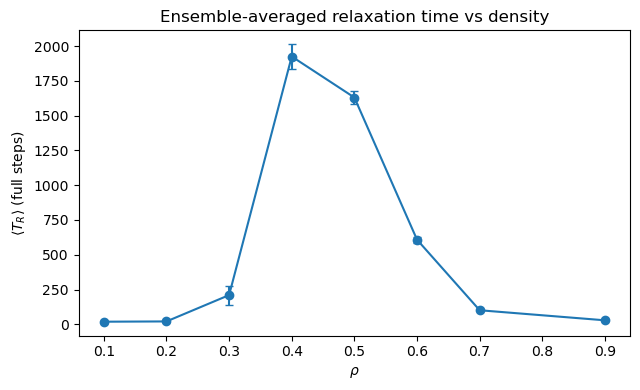

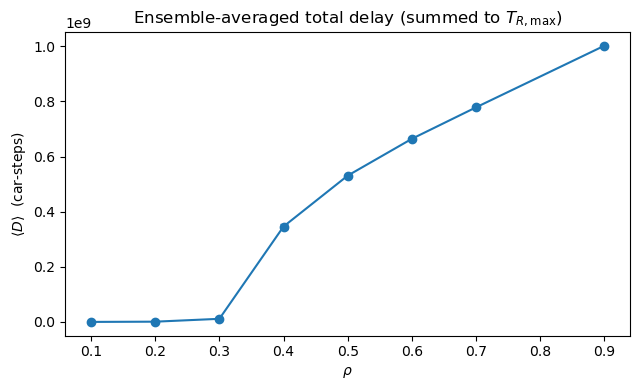

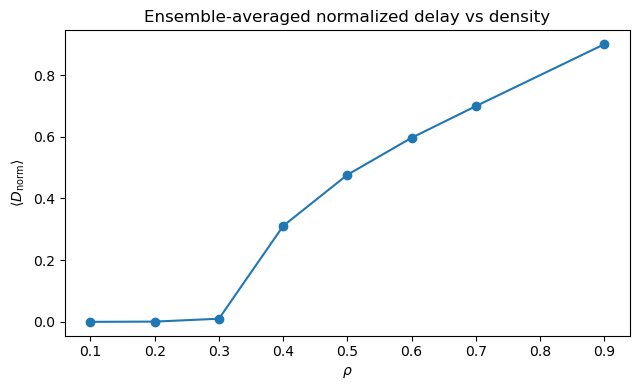

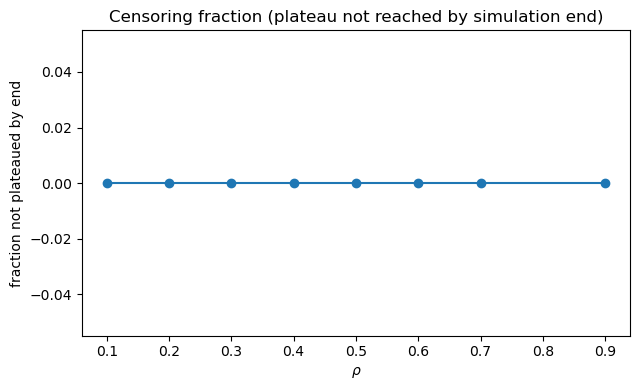

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# PARAMETERS
# ============================================================
L = 500
RHOS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
DATA_DIR = Path("./bml_3D_data_rho_scan")

# Relaxation detection (noisy plateau friendly)
SMOOTH_W = 50
TAIL_W = 500
PERSIST_W = 300
K_SIGMA = 3
EPS_MIN = 0.005

# Use SEM for error bars? (physicist default)
USE_SEM = True  # False -> std

# ============================================================
# IO
# ============================================================
def rho_tag(rho):
    return f"rho{int(round(rho * 100))}"

def read_vel_bin(path: Path) -> np.ndarray:
    """
    Binary format:
      int32 T
      int32 M
      M*T float64, row-major [m][t]
    Returns: array shape (M, T)
    """
    with open(path, "rb") as f:
        T = np.fromfile(f, dtype=np.int32, count=1)[0]
        M = np.fromfile(f, dtype=np.int32, count=1)[0]
        data = np.fromfile(f, dtype=np.float64, count=M * T)
    return data.reshape(M, T)

# ============================================================
# Plateau-based relaxation time
# ============================================================
def smooth(v: np.ndarray, W: int) -> np.ndarray:
    if W <= 1:
        return v.copy()
    kernel = np.ones(W) / W
    return np.convolve(v, kernel, mode="same")

def relaxation_time(v: np.ndarray,
                    smooth_window=SMOOTH_W,
                    tail_window=TAIL_W,
                    persist_window=PERSIST_W,
                    k_sigma=K_SIGMA,
                    eps_min=EPS_MIN) -> int:
    """
    Returns T_R as a 0-based time index.
    If not detected by end -> returns T-1 (censored).
    """
    T = len(v)
    vs = smooth(v, smooth_window)

    tw = min(tail_window, T)
    tail = vs[-tw:]
    v_inf = np.median(tail)
    sigma = np.std(tail)
    eps = max(eps_min, k_sigma * sigma)

    last_start = T - persist_window
    if last_start <= 0:
        return T - 1

    for t in range(last_start):
        win = vs[t:t + persist_window]
        if np.all(np.abs(win - v_inf) <= eps):
            return t

    return T - 1

def errbar(x):
    """std or SEM depending on USE_SEM"""
    x = np.asarray(x)
    s = np.std(x, ddof=1) if len(x) > 1 else 0.0
    if USE_SEM:
        return s / np.sqrt(len(x)) if len(x) > 0 else 0.0
    return s

# ============================================================
# MAIN: compute per-run TR, global TR_max, delays, and plot
# ============================================================
def main():
    # ---- pass 1: compute TR for every run, every rho ----
    TR_all = {}
    T_common = None

    for rho in RHOS:
        v_all = read_vel_bin(DATA_DIR / f"vel_{rho_tag(rho)}.bin")
        M, T = v_all.shape
        if T_common is None:
            T_common = T
        elif T != T_common:
            raise ValueError(f"Not all densities have same T: got {T} vs {T_common}")

        TR = np.array([relaxation_time(v_all[m]) for m in range(M)], dtype=int)
        TR_all[rho] = TR

    # ---- global TR_max ----
    T_R_max = max(TR.max() for TR in TR_all.values())
    print(f"T_R_max (0-based index) = {T_R_max}  |  (full-step count) = {T_R_max+1}")

    # IMPORTANT: choose slice convention ONCE
    # Here: sum over timesteps t=0..T_R_max inclusive => use cut = T_R_max+1
    cut = min(T_R_max + 1, T_common)
    denom_norm = (L * L * cut)  # L^2 * T_R_max (as number of steps)

    # ---- pass 2: compute delays using global cutoff ----
    delay_all = {}
    delay_norm_all = {}

    for rho in RHOS:
        v_all = read_vel_bin(DATA_DIR / f"vel_{rho_tag(rho)}.bin")
        M, T = v_all.shape
        N = rho * L * L

        delays = np.sum((1.0 - v_all[:, :cut]) * N, axis=1)
        delays_norm = delays / denom_norm

        delay_all[rho] = delays
        delay_norm_all[rho] = delays_norm

    # ---- ensemble stats vs rho ----
    rhos = np.array(RHOS, dtype=float)

    TR_mean = np.array([np.mean(TR_all[r]) for r in RHOS])
    TR_err  = np.array([errbar(TR_all[r]) for r in RHOS])

    D_mean  = np.array([np.mean(delay_all[r]) for r in RHOS])
    D_err   = np.array([errbar(delay_all[r]) for r in RHOS])

    Dn_mean = np.array([np.mean(delay_norm_all[r]) for r in RHOS])
    Dn_err  = np.array([errbar(delay_norm_all[r]) for r in RHOS])

    cens_frac = np.array([np.mean(TR_all[r] == (T_common - 1)) for r in RHOS])

    # ---- PLOTS (3 separate figures, clean) ----
    # 1) <T_R>(rho)
    plt.figure(figsize=(6.5, 4))
    plt.errorbar(rhos, TR_mean, yerr=TR_err, fmt='o-', capsize=3)
    plt.xlabel(r'$\rho$')
    plt.ylabel(r'$\langle T_R \rangle$ (full steps)')
    plt.title(r'Ensemble-averaged relaxation time vs density')
    # convert 0-based index to "full steps" by +1 for readability
    plt.gca().lines[0].set_ydata(TR_mean + 1)
    plt.tight_layout()
    plt.show()

    # 2) <Delay>(rho)
    plt.figure(figsize=(6.5, 4))
    plt.errorbar(rhos, D_mean, yerr=D_err, fmt='o-', capsize=3)
    plt.xlabel(r'$\rho$')
    plt.ylabel(r'$\langle D \rangle$  (car-steps)')
    plt.title(r'Ensemble-averaged total delay (summed to $T_{R,\max}$)')
    plt.tight_layout()
    plt.show()

    # 3) <Normalized Delay>(rho)
    plt.figure(figsize=(6.5, 4))
    plt.errorbar(rhos, Dn_mean, yerr=Dn_err, fmt='o-', capsize=3)
    plt.xlabel(r'$\rho$')
    plt.ylabel(r'$\langle D_{\mathrm{norm}} \rangle$')
    plt.title(r'Ensemble-averaged normalized delay vs density')
    plt.tight_layout()
    plt.show()

    # OPTIONAL but super useful: censored fraction vs rho
    plt.figure(figsize=(6.5, 4))
    plt.plot(rhos, cens_frac, 'o-')
    plt.xlabel(r'$\rho$')
    plt.ylabel('fraction not plateaued by end')
    plt.title('Censoring fraction (plateau not reached by simulation end)')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
